In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from random import randint
import random

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [4]:
# Load mnist data
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
num_classes = 10

# preprocessing
train_images = train_images / 255.0
test_images = test_images / 255.0

# change labels to categorical
train_labels_bin = keras.utils.to_categorical(train_labels, num_classes)
test_labels_bin = keras.utils.to_categorical(test_labels, num_classes)

# Find the indeces of each number
number_ind = []
for i in range(10):
  number_ind.append(train_labels == i)

In [6]:
# Simple NN model
def mnistModel():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10, activation='softmax')
  ])
    
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
             metrics=['accuracy'])
  return model


def addNoise(model, noise):
    newModel = mnistModel()
    for layer_index in range(len(model.weights)):
        layer_shape = model.weights[layer_index].shape
        layer_noise = np.random.uniform(-noise/2, noise/2, size=layer_shape)
        #layer_noise = np.random.uniform(0, noise, size=layer_shape)
        #layer_noise = np.random.normal(0, noise, size=layer_shape)
        newModel.weights[layer_index].assign(model.weights[layer_index]+layer_noise)
        
    return newModel

def setAccuracy(model, test_images, test_labels_bin, accuracyFrac, allowedDev):
    initialAcc = model.evaluate(test_images, test_labels_bin, batch_size=128)
    targetAcc = initialAcc[1]*accuracyFrac
    print("target:",targetAcc)
    hiNoise = 10
    lowNoise = 0
    
    noisyModel = addNoise(model,(hiNoise+lowNoise)/2)
    currAcc = noisyModel.evaluate(test_images, test_labels_bin, batch_size=128)
    print("curr",currAcc[1])
    iterations = 0
    retry_count = 0
    while ((abs(currAcc[1]-targetAcc) > allowedDev) and iterations < 30):
        
        if ((currAcc[1] - targetAcc > 0.03) or (retry_count > 2)):
            retry_count = 0
            
            if (currAcc[1] > targetAcc):
                lowNoise = (hiNoise+lowNoise)/2
            else:
                hiNoise =  (hiNoise+lowNoise)/2

            print("low", lowNoise)
            print("high", hiNoise)

            noisyModel = addNoise(model,(hiNoise+lowNoise)/2)
            currAcc = noisyModel.evaluate(test_images, test_labels_bin, batch_size=128)

            print("curr",currAcc[1])
            iterations += 1
        else:
            retry_count += 1
        
    return noisyModel



#### CIFAR

In [6]:
# ## CIFAR DATASET AND MODEL

# cifar10 = keras.datasets.cifar10
# (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# num_classes = 10

# # preprocessing
# train_images = train_images / 255.0
# test_images = test_images / 255.0

# # normalize images
# train_images_norm = (train_images - np.mean(train_images, axis=(0, 1, 2, 3))) / np.std(train_images, axis=(0, 1, 2, 3))
# test_images_norm = (test_images - np.mean(test_images, axis=(0, 1, 2, 3))) / np.std(test_images, axis=(0, 1, 2, 3))

# # change labels to categorical
# train_labels_bin = keras.utils.to_categorical(train_labels, num_classes)
# test_labels_bin = keras.utils.to_categorical(test_labels, num_classes)

# def cifar10model():
#   # define the model; architecture inspired by Keras documentation
#   model = keras.Sequential([
#       keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=train_images.shape[1:], activation='relu'),
#       keras.layers.Conv2D(32, (3, 3), activation='relu'),
#       keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       keras.layers.Dropout(0.25),
#       keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#       keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
#       keras.layers.MaxPooling2D(pool_size=(2, 2)),
#       keras.layers.Dropout(0.25),
#       keras.layers.Flatten(),
#       keras.layers.Dense(512, activation='relu'),
#       keras.layers.Dropout(0.5),
#       keras.layers.Dense(num_classes, activation='softmax')
#   ])
#   model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#              metrics=['accuracy'])
#   return model

### Standard Training

In [55]:
model = mnistModel()

In [56]:
model.summary()

Model: "sequential_239"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_239 (Flatten)        (None, 784)               0         
_________________________________________________________________
dense_478 (Dense)            (None, 128)               100480    
_________________________________________________________________
dense_479 (Dense)            (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [57]:
train_results = model.fit(train_images, train_labels_bin, batch_size=32, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 15s 256us/sample - loss: 0.2578 - acc: 0.9271
Epoch 2/10
60000/60000 [==============================] - 15s 243us/sample - loss: 0.1132 - acc: 0.9662 - lo
Epoch 3/10
60000/60000 [==============================] - 16s 262us/sample - loss: 0.0779 - acc: 0.9767
Epoch 4/10
60000/60000 [==============================] - 16s 267us/sample - loss: 0.0581 - acc: 0.9822
Epoch 5/10
60000/60000 [==============================] - 16s 267us/sample - loss: 0.0441 - acc: 0.9863
Epoch 6/10
60000/60000 [==============================] - 16s 268us/sample - loss: 0.0344 - acc: 0.9898
Epoch 7/10
60000/60000 [==============================] - 18s 307us/sample - loss: 0.0270 - acc: 0.9916 
Epoch 8/10
60000/60000 [==============================] - 15s 252us/sample - loss: 0.0228 - acc: 0.9930
Epoch 9/10
60000/60000 [==============================] - 16s 274us/sample - loss: 0.0170 - acc: 0.9947
Epoch 10/10
60000/60000 [==============================] -

In [160]:
results = model.evaluate(test_images, test_labels_bin, batch_size=128)
newModel = setAccuracy(model, test_images, test_labels_bin, 0.9, 0.005)
#results2 = newModel.evaluate(test_images, test_labels_bin, batch_size=128)



10000/10000 [==============================] - 1s 98us/sample - loss: 0.0717 - acc: 0.9790
target: 0.8810999751091003
10000/10000 [==============================] - 1s 101us/sample - loss: 13.7807 - acc: 0.1345
curr 0.1345
low 0
high 5.0
10000/10000 [==============================] - 1s 95us/sample - loss: 13.2410 - acc: 0.1225
curr 0.1225
low 0
high 2.5
10000/10000 [==============================] - 1s 86us/sample - loss: 5.8405 - acc: 0.4827
curr 0.4827
low 0
high 1.25
10000/10000 [==============================] - 1s 92us/sample - loss: 0.4616 - acc: 0.8878
curr 0.8878
low 0.625
high 1.25
10000/10000 [==============================] - 1s 101us/sample - loss: 3.0173 - acc: 0.5728
curr 0.5728
low 0.625
high 0.9375
10000/10000 [==============================] - 1s 99us/sample - loss: 1.1406 - acc: 0.7921
curr 0.7921
low 0.625
high 0.78125
10000/10000 [==============================] - 1s 103us/sample - loss: 0.9062 - acc: 0.8143
curr 0.8143
low 0.625
high 0.703125
10000/10000 [========

In [161]:
newModel.evaluate(test_images, test_labels_bin, batch_size=128)[1]-0.8810999751091003

10000/10000 [==============================] - 1s 76us/sample - loss: 0.5337 - acc: 0.8775


-0.0035999774932861106

In [153]:
results2 = addNoise(model, 5).evaluate(test_images, test_labels_bin, batch_size=128)

10000/10000 [==============================] - 1s 82us/sample - loss: 13.7293 - acc: 0.1387


In [43]:
print(results2[1])

0.8202


In [9]:
sns.lineplot(list(range(len(train_results.history['accuracy']))), train_results.history['accuracy'])
plt.title('Standard mnist Training Accuracy')
plt.xlabel('Epoch')
plt.show()

KeyError: 'accuracy'

### Setup for Federated Learning

In [8]:
class FederatedClient:
  trainImages = None
  trainLabels = None
  model = None

  def __init__(self, model, trainImages, trainLabels):
    self.model = model
    self.trainImages = trainImages
    self.trainLabels = trainLabels

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      self.model.weights[layer_index].assign(serverModel.weights[layer_index])
  
  def fit(self):
    self.model.fit(self.trainImages, self.trainLabels, batch_size=32, epochs=1)

  def getModel(self):
    return self.model

  def evaluate(self, testImages, testLabels, globalAccuracy, batch_size=32):
    # evaluate accuracy and utility. 
    acc = self.evaluate_accuracy(testImages, testLabels, batch_size)
    utility = self.evaluate_utility(acc[1], globalAccuracy)
    return acc, utility

  def evaluate_accuracy(self, testImages, testLabels, batch_size=32):
    return self.model.evaluate(testImages, testLabels, batch_size)

  def evaluate_utility(self, localAccuracy, globalAccuracy):
    # utility = local acc - global acc
    return localAccuracy - globalAccuracy

In [19]:
# Server class holds a server model and testing data
class FederatedServer:

  model = None
  testImages = None
  testLabels = None

  def __init__(self, model, testImages, testLabels):
    self.model = model
    self.testImages = testImages
    self.testLabels = testLabels

  # Averaging client models using the averaging method
  def average(self, federatedClients, averagingMethod):
    allWeights = []

    for i in range(len(federatedClients)):
      allWeights.append(federatedClients[i].getModel().weights)
    
    avgWeights = averagingMethod(allWeights) 
    
    for layer_index in range(len(avgWeights)):
      self.model.weights[layer_index].assign(avgWeights[layer_index])
  
  # evaluate the test accuracies and utility for all clients
  def evaluate_clients(self, federatedClients, globalAccuracy):
    results = []
    for client in federatedClients:
      results.append(client.evaluate(self.testImages, self.testLabels, globalAccuracy, batch_size=32))
    return results

  # Testing the server model
  def evaluate(self):
    return self.model.evaluate(self.testImages, self.testLabels, batch_size=32)

In [20]:
# Adversarial Client 1: returns a constant (all ones) for every weight in the model
class AdversarialClient(FederatedClient):
  fakeModel = None
  
  def __init__(self, model, trainImages, trainLabels, fakeModel):
    super(AdversarialClient, self).__init__(model, trainImages, trainLabels)
    self.fakeModel = fakeModel

  
  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(np.ones(layer_shape))

  def fit(self):
    pass
  
  def getModel(self):
    return self.fakeModel

In [21]:
# Adversarial Client 2: returns a Uniform(0, 1) value for each weight in model
class AdversarialClient2(AdversarialClient):


  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(np.random.uniform(size = layer_shape))

  def fit(self):
    pass

In [22]:
# Adversarial Client 3: returns noisy trained model, then substracts noise from aggregate model to get more useful model
class AdversarialClient3(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel, num_clients=10):
    super(AdversarialClient3, self).__init__(model, trainImages, trainLabels, fakeModel)
    self.noise = None
    self.num_clients = num_clients # assume number of participating clients is known by adversary

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])
    
    # compute the "true" model by removing noise
    if self.noise != None:
      for layer_index in range(len(self.model.weights)):
        self.model.weights[layer_index].assign(self.fakeModel.weights[layer_index] - self.noise[layer_index] / self.num_clients)

  def fit(self):
    # fit the model properly
    FederatedClient.fit(self)
    
    # add and save Gaussian noise
    self.noise = []
    for layer_index in range(len(self.model.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      layer_noise = np.random.uniform(-1, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.fakeModel.weights[layer_index].assign(self.model.weights[layer_index] + layer_noise)



In [23]:
# Adversarial Client 4: Returns a random model, saves first iteration's model and improves upon it  
class AdversarialClient4(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel, num_clients=10):
    super(AdversarialClient4, self).__init__(model, trainImages, trainLabels, fakeModel)
    self.noise = None
    self.num_clients = num_clients # assume number of participating clients is known by adversary
    self.counter  = 0 

  def assignServerModel(self, serverModel):   
    if (self.counter == 1):
      for layer_index in range(len(self.model.weights)):
        self.model.weights[layer_index].assign(serverModel.weights[layer_index]- self.noise[layer_index]/self.num_clients + self.model.weights[layer_index]/self.num_clients)

    self.counter += 1

  def fit(self):
    # fit the model properly
    FederatedClient.fit(self)
    
    # add and save Gaussian noise
    self.noise = []
    for layer_index in range(len(self.model.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      layer_noise = np.random.uniform(0, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.fakeModel.weights[layer_index].assign(layer_noise)


In [24]:
# Adversarial Client non IID: Does not help or hurt, and improves upon final model locally  
class AdversarialClientNonIID(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel):
    super(AdversarialClientNonIID, self).__init__(model, trainImages, trainLabels, fakeModel)

  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])

    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.model.weights[layer_index].shape
      self.model.weights[layer_index].assign(serverModel.weights[layer_index])

  def fit(self):
    # fit the model properly
    FederatedClient.fit(self)

In [25]:
# Adversarial Client 5: returns noisy trained model, then substracts noise from aggregate model
# to get more useful model in slightly different way than Adversarial Client 3 
class AdversarialClient5(AdversarialClient):
  def __init__(self, model, trainImages, trainLabels, fakeModel, num_clients=10):
    super(AdversarialClient5, self).__init__(model, trainImages, trainLabels, fakeModel)
    self.noise = None
    self.num_clients = num_clients # assume number of participating clients is known by adversary
    self.round_num = 0 
    self.noNoiseModel = mnistModel()
    
  def assignServerModel(self, serverModel):
    for layer_index in range(len(serverModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      self.fakeModel.weights[layer_index].assign(serverModel.weights[layer_index])
    

    # compute the "no noise" model by removing noise
    if self.noise != None:
      for layer_index in range(len(self.fakeModel.weights)):
        self.noNoiseModel.weights[layer_index].assign(self.fakeModel.weights[layer_index] - self.noise[layer_index] / self.num_clients)


  def fit(self):
    self.fakeModel.fit(self.trainImages, self.trainLabels, batch_size=128, epochs=1)
    
    # add and save noise
    self.noise = []
    for layer_index in range(len(self.fakeModel.weights)):
      layer_shape = self.fakeModel.weights[layer_index].shape
      layer_noise = np.random.uniform(-1, 1, size=layer_shape)
      self.noise.append(layer_noise)
      self.fakeModel.weights[layer_index].assign(self.fakeModel.weights[layer_index] + layer_noise)

    # update true model 
    self.noNoiseModel.fit(self.trainImages, self.trainLabels, batch_size=128, epochs=1)
    
    for layer_index in range(len(self.model.weights)):
      #(prev_avg * n + x) / (n + 1)
      self.model.weights[layer_index].assign((self.model.weights[layer_index] * self.round_num + self.noNoiseModel.weights[layer_index]) / (self.round_num +1)) 
    self.round_num = self.round_num + 1
    


  #def evaluate_accuracy(self, testImages, testLabels, batch_size=32):
  #  return self.trueModel.evaluate(testImages, testLabels, batch_size)

### Sampling Scheme

In [26]:
def sample_iid(train_labels, data_percentage):
    total_data = train_labels.shape[0]
    indices_all = np.array([randint(0, NUM_CLIENTS-1) for _ in range(total_data)])
    # add a mask
    mask = random.sample(list(range(total_data)), int(total_data * (1 - data_percentage)))
    indices_all[mask] = -1
    return indices_all

In [27]:
def sample_non_iid(train_labels, data_percentage, random_mix=0.5):
    total_data = train_labels.shape[0]
    ### Set client to have a single class of data (NEED TO CHANGE IF # OF CLIENTS CHANGES)
    indices_all = np.array(train_labels)

    n_random = int(total_data * random_mix)
    random_indices = random.sample(list(range(total_data)), n_random)
    indices_all[random_indices] = np.array([randint(0, NUM_CLIENTS-1) for _ in range(n_random)])

    # add a mask
    mask = random.sample(list(range(total_data)), int(total_data * (1 - data_percentage)))
    indices_all[mask] = -1
    return indices_all

### Standard Federated Learning
Using `FedAvg` under IID non-adversarial setting.

In [28]:
def FederatedLearn(numRounds, federatedServer, federatedClients, averagingMethod, noiseStd):
  test_accs = []
  client_results = []
  
  # federated learning
  for r in range(numRounds):

    for i in range(len(federatedClients)):
#      print('Round #' + str(r + 1) + ' Device #' + str(i + 1))

      federatedClients[i].assignServerModel(addNoise(federatedServer.model, noiseStd[i]))

    #print('before')
    #federatedServer.evaluate_clients(federatedClients,0)

    for i in range(len(federatedClients)):
      print('Round #' + str(r + 1) + ' Device #' + str(i + 1))

      # train local device
      federatedClients[i].fit()
      
    # update server model with weights averaging
    federatedServer.average(federatedClients, averagingMethod)
    
    # test evaluation on server model
    print('Round #' + str(r + 1) + ' Testing')
    test_acc = federatedServer.evaluate()
    print('Round #' + str(r + 1) +' Test Accuracy:', test_acc[1])
    test_accs.append(test_acc)

    #print('after')
    # evaluate test accuracy and utility for each client
    #client_results.append(federatedServer.evaluate_clients(federatedClients, test_acc[1]))
  
  return test_accs, client_results

In [29]:
def myMean(weights):
  return np.mean(weights, axis=0)


def myMedian(list_of_weights):
  # use median over all network weights
  robust_weights = []
  for layer in range(len(list_of_weights[0])):
    layer_shape = list_of_weights[0][layer].shape
    layer_list = [list_of_weights[i][layer].numpy().flatten() for i in range(len(list_of_weights))]
    robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
  return robust_weights


In [162]:
NUM_ROUNDS = 20
NUM_CLIENTS = 10
DATA_PERCENTAGE = 0.1

#indices = sample_iid(train_labels, DATA_PERCENTAGE)
indices = sample_non_iid(train_labels, DATA_PERCENTAGE, 0.1)


# Standard Federated Learning
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs, clientResults = FederatedLearn(NUM_ROUNDS, server, clients, myMedian, 
                                         [1,0.1,0,0.5,0.2,0.01,0,0.01,1,0.1])


Round #1 Device #1
611/611 [==============================] - 1s 1ms/sample - loss: 2.0453 - acc: 0.7447
Round #1 Device #2
685/685 [==============================] - 1s 821us/sample - loss: 0.8919 - acc: 0.8029
Round #1 Device #3
635/635 [==============================] - 1s 886us/sample - loss: 0.7265 - acc: 0.8504
Round #1 Device #4
609/609 [==============================] - 1s 924us/sample - loss: 1.2688 - acc: 0.7274
Round #1 Device #5
580/580 [==============================] - 1s 998us/sample - loss: 0.8091 - acc: 0.8276
Round #1 Device #6
572/572 [==============================] - 1s 963us/sample - loss: 0.8652 - acc: 0.8182
Round #1 Device #7
542/542 [==============================] - 0s 901us/sample - loss: 0.9964 - acc: 0.7804
Round #1 Device #8
603/603 [==============================] - 1s 935us/sample - loss: 0.7686 - acc: 0.8408
Round #1 Device #9
580/580 [==============================] - 1s 993us/sample - loss: 6.4621 - acc: 0.3914
Round #1 Device #10
583/583 [==========

572/572 [==============================] - 0s 472us/sample - loss: 0.3500 - acc: 0.9161
Round #8 Device #7
542/542 [==============================] - 0s 453us/sample - loss: 0.1735 - acc: 0.9686
Round #8 Device #8
603/603 [==============================] - 0s 312us/sample - loss: 0.1985 - acc: 0.9519
Round #8 Device #9
580/580 [==============================] - 0s 422us/sample - loss: 6.2889 - acc: 0.4155
Round #8 Device #10
583/583 [==============================] - 0s 377us/sample - loss: 0.3952 - acc: 0.8851
Round #8 Testing
10000/10000 [==============================] - 3s 285us/sample - loss: 0.8648 - acc: 0.7306
Round #8 Test Accuracy: 0.7306
10000/10000 [==============================] - 3s 254us/sample - loss: 3.0289 - acc: 0.3490
Round #9 Device #1
611/611 [==============================] - 0s 236us/sample - loss: 9.0778 - acc: 0.2668
Round #9 Device #2
685/685 [==============================] - 0s 299us/sample - loss: 0.1773 - acc: 0.9591
Round #9 Device #3
635/635 [=========

10000/10000 [==============================] - 3s 258us/sample - loss: 2.5502 - acc: 0.4492
Round #16 Device #1
611/611 [==============================] - 0s 208us/sample - loss: 7.6364 - acc: 0.3732
Round #16 Device #2
685/685 [==============================] - 0s 338us/sample - loss: 0.1180 - acc: 0.9737
Round #16 Device #3
635/635 [==============================] - 0s 414us/sample - loss: 0.1599 - acc: 0.9559
Round #16 Device #4
609/609 [==============================] - 0s 482us/sample - loss: 0.4004 - acc: 0.8966
Round #16 Device #5
580/580 [==============================] - 0s 441us/sample - loss: 0.4986 - acc: 0.8362
Round #16 Device #6
572/572 [==============================] - 0s 425us/sample - loss: 0.2193 - acc: 0.9476
Round #16 Device #7
542/542 [==============================] - 0s 342us/sample - loss: 0.0960 - acc: 0.9834
Round #16 Device #8
603/603 [==============================] - 0s 439us/sample - loss: 0.1124 - acc: 0.9751
Round #16 Device #9
580/580 [===============

572/572 [==============================] - 0s 495us/sample - loss: 0.1766 - acc: 0.9580
Round #19 Device #7
542/542 [==============================] - 0s 417us/sample - loss: 0.0839 - acc: 0.9852
Round #19 Device #8
603/603 [==============================] - 0s 486us/sample - loss: 0.0998 - acc: 0.9735
Round #19 Device #9
580/580 [==============================] - 0s 453us/sample - loss: 1.6237 - acc: 0.7655
Round #19 Device #10
583/583 [==============================] - 0s 401us/sample - loss: 0.1954 - acc: 0.9520
Round #19 Testing
10000/10000 [==============================] - 2s 223us/sample - loss: 0.5742 - acc: 0.8253s - loss: 0.6348
Round #19 Test Accuracy: 0.8253
10000/10000 [==============================] - 2s 212us/sample - loss: 2.0764 - acc: 0.4952
Round #20 Device #1
611/611 [==============================] - 0s 207us/sample - loss: 2.2109 - acc: 0.7218
Round #20 Device #2
685/685 [==============================] - 0s 355us/sample - loss: 0.1101 - acc: 0.9781
Round #20 Dev

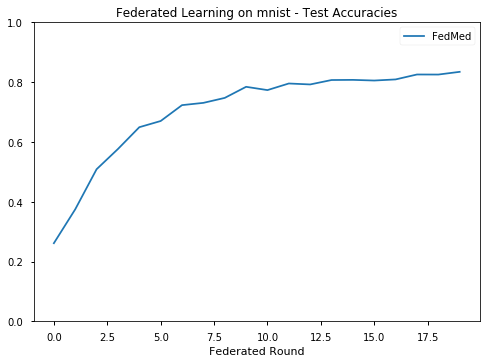

[[2.2123700424194337, 0.2612], [1.8924675226211547, 0.3746], [1.566746266555786, 0.5086], [1.3252578149795533, 0.5763], [1.1323861707687377, 0.6492], [1.0330173800468445, 0.6699], [0.8998456721305848, 0.723], [0.8648235295295715, 0.7306], [0.7881304669380188, 0.7472], [0.7332993553161621, 0.7843], [0.718989869594574, 0.7733], [0.6826287509441376, 0.7954], [0.6692748667240143, 0.7922], [0.6411776840209961, 0.807], [0.6326846762657166, 0.8075], [0.6204221518993378, 0.8053], [0.614687969493866, 0.809], [0.5701683331489563, 0.8255], [0.5742327914237976, 0.8253], [0.5508256978034973, 0.8344]]


In [163]:
plotServerAccuracy([testAccs,], ['FedMed',], 'noise.jpg')
print(testAccs)

In [164]:
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs2, clientResults2 = FederatedLearn(NUM_ROUNDS, server, clients, myMedian, 
                                             [0 for _ in range(10)])

clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs3, clientResults3 = FederatedLearn(NUM_ROUNDS, server, clients, myMean, 
                                         [1,0.1,0,0.5,0.2,0.01,0,0.01,1,0.1])

Round #1 Device #1
611/611 [==============================] - 1s 870us/sample - loss: 0.6445 - acc: 0.8592
Round #1 Device #2
685/685 [==============================] - 1s 792us/sample - loss: 0.6501 - acc: 0.8993
Round #1 Device #3
635/635 [==============================] - 1s 931us/sample - loss: 0.6281 - acc: 0.8803
Round #1 Device #4
609/609 [==============================] - 1s 973us/sample - loss: 0.8724 - acc: 0.8062
Round #1 Device #5
580/580 [==============================] - 1s 2ms/sample - loss: 0.9412 - acc: 0.8241
Round #1 Device #6
572/572 [==============================] - 1s 881us/sample - loss: 0.8661 - acc: 0.8357
Round #1 Device #7
542/542 [==============================] - 1s 1ms/sample - loss: 0.8316 - acc: 0.8395
Round #1 Device #8
603/603 [==============================] - 0s 784us/sample - loss: 0.9413 - acc: 0.8043
Round #1 Device #9
580/580 [==============================] - 0s 806us/sample - loss: 0.7193 - acc: 0.8414
Round #1 Device #10
583/583 [============

580/580 [==============================] - 0s 509us/sample - loss: 0.3646 - acc: 0.8966
Round #8 Device #10
583/583 [==============================] - 0s 460us/sample - loss: 0.2751 - acc: 0.9537
Round #8 Testing
10000/10000 [==============================] - 3s 261us/sample - loss: 0.6651 - acc: 0.8408
Round #8 Test Accuracy: 0.8408
10000/10000 [==============================] - 2s 207us/sample - loss: 2.6282 - acc: 0.4049
Round #9 Device #1
611/611 [==============================] - 0s 227us/sample - loss: 0.1241 - acc: 0.9804
Round #9 Device #2
685/685 [==============================] - 0s 350us/sample - loss: 0.1537 - acc: 0.9693
Round #9 Device #3
635/635 [==============================] - 0s 447us/sample - loss: 0.2851 - acc: 0.9071
Round #9 Device #4
609/609 [==============================] - 0s 480us/sample - loss: 0.3571 - acc: 0.9097
Round #9 Device #5
580/580 [==============================] - 0s 371us/sample - loss: 0.2907 - acc: 0.9345
Round #9 Device #6
572/572 [=========

10000/10000 [==============================] - 2s 230us/sample - loss: 2.2772 - acc: 0.4313
Round #16 Device #1
611/611 [==============================] - 0s 203us/sample - loss: 0.1029 - acc: 0.9722
Round #16 Device #2
685/685 [==============================] - 0s 371us/sample - loss: 0.0783 - acc: 0.9912s - loss: 0.1079 - acc: 0.9
Round #16 Device #3
635/635 [==============================] - 0s 414us/sample - loss: 0.2575 - acc: 0.9197
Round #16 Device #4
609/609 [==============================] - 0s 415us/sample - loss: 0.2491 - acc: 0.9343
Round #16 Device #5
580/580 [==============================] - 0s 504us/sample - loss: 0.2050 - acc: 0.9552
Round #16 Device #6
572/572 [==============================] - 0s 437us/sample - loss: 0.2962 - acc: 0.9213
Round #16 Device #7
542/542 [==============================] - 0s 467us/sample - loss: 0.1253 - acc: 0.9723
Round #16 Device #8
603/603 [==============================] - 0s 436us/sample - loss: 0.1606 - acc: 0.9585
Round #16 Device 

580/580 [==============================] - 0s 494us/sample - loss: 0.8727 - acc: 0.7690
Round #3 Device #6
572/572 [==============================] - 0s 473us/sample - loss: 0.8526 - acc: 0.8129
Round #3 Device #7
542/542 [==============================] - 0s 377us/sample - loss: 0.7079 - acc: 0.8524
Round #3 Device #8
603/603 [==============================] - 0s 420us/sample - loss: 0.6378 - acc: 0.8806
Round #3 Device #9
580/580 [==============================] - 0s 459us/sample - loss: 3.4109 - acc: 0.5414
Round #3 Device #10
583/583 [==============================] - 0s 408us/sample - loss: 0.6415 - acc: 0.8971
Round #3 Testing
10000/10000 [==============================] - 2s 241us/sample - loss: 1.8726 - acc: 0.3822
Round #3 Test Accuracy: 0.3822
10000/10000 [==============================] - 2s 240us/sample - loss: 4.5363 - acc: 0.1015
Round #4 Device #1
611/611 [==============================] - 0s 204us/sample - loss: 14.9491 - acc: 0.0115
Round #4 Device #2
685/685 [========

10000/10000 [==============================] - 3s 274us/sample - loss: 1.1417 - acc: 0.6314
Round #10 Test Accuracy: 0.6314
10000/10000 [==============================] - 3s 252us/sample - loss: 2.7421 - acc: 0.4016s - loss: 2.7579 - acc: 0.4
Round #11 Device #1
611/611 [==============================] - 0s 220us/sample - loss: 2.2923 - acc: 0.6727
Round #11 Device #2
685/685 [==============================] - 0s 426us/sample - loss: 0.1943 - acc: 0.9577
Round #11 Device #3
635/635 [==============================] - 0s 455us/sample - loss: 0.2783 - acc: 0.9213
Round #11 Device #4
609/609 [==============================] - 0s 399us/sample - loss: 1.4655 - acc: 0.6568
Round #11 Device #5
580/580 [==============================] - 0s 550us/sample - loss: 0.5192 - acc: 0.8414
Round #11 Device #6
572/572 [==============================] - 0s 413us/sample - loss: 0.5627 - acc: 0.8549
Round #11 Device #7
542/542 [==============================] - 0s 417us/sample - loss: 0.3026 - acc: 0.9133
R

10000/10000 [==============================] - 3s 283us/sample - loss: 3.8214 - acc: 0.3395
Round #18 Device #1
611/611 [==============================] - 0s 205us/sample - loss: 7.4329 - acc: 0.3846
Round #18 Device #2
685/685 [==============================] - 0s 406us/sample - loss: 0.1626 - acc: 0.9591
Round #18 Device #3
635/635 [==============================] - 0s 468us/sample - loss: 0.3244 - acc: 0.8961
Round #18 Device #4
609/609 [==============================] - 0s 504us/sample - loss: 0.5550 - acc: 0.8654
Round #18 Device #5
580/580 [==============================] - 0s 557us/sample - loss: 0.3070 - acc: 0.9155
Round #18 Device #6
572/572 [==============================] - 0s 585us/sample - loss: 0.4912 - acc: 0.8497
Round #18 Device #7
542/542 [==============================] - 0s 480us/sample - loss: 0.2316 - acc: 0.9354
Round #18 Device #8
603/603 [==============================] - 0s 484us/sample - loss: 0.2237 - acc: 0.9254s - loss: 0.2890 - acc: 0.9
Round #18 Device 

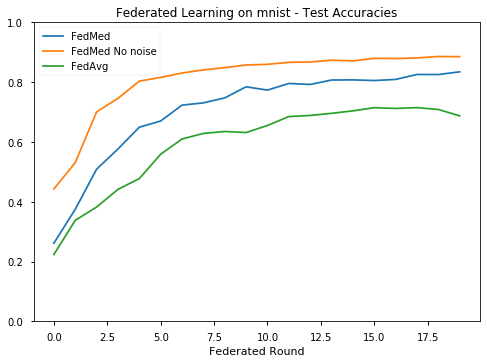

[[2.2123700424194337, 0.2612], [1.8924675226211547, 0.3746], [1.566746266555786, 0.5086], [1.3252578149795533, 0.5763], [1.1323861707687377, 0.6492], [1.0330173800468445, 0.6699], [0.8998456721305848, 0.723], [0.8648235295295715, 0.7306], [0.7881304669380188, 0.7472], [0.7332993553161621, 0.7843], [0.718989869594574, 0.7733], [0.6826287509441376, 0.7954], [0.6692748667240143, 0.7922], [0.6411776840209961, 0.807], [0.6326846762657166, 0.8075], [0.6204221518993378, 0.8053], [0.614687969493866, 0.809], [0.5701683331489563, 0.8255], [0.5742327914237976, 0.8253], [0.5508256978034973, 0.8344]]
[[1.8848653755187987, 0.4426], [1.586559888458252, 0.5307], [1.2642111446380615, 0.7002], [1.0395028270721436, 0.7457], [0.8811164281845093, 0.8032], [0.7871402858734131, 0.8158], [0.718896700668335, 0.8304], [0.6651294614791871, 0.8408], [0.6220400958061219, 0.8485], [0.5873001741409302, 0.8572], [0.5614493441581726, 0.8595], [0.5377947308540344, 0.8662], [0.519843100309372, 0.8673], [0.50009568629264

In [166]:
plotServerAccuracy([testAccs,testAccs2,testAccs3], ['FedMed','FedMed No noise', 'FedAvg'], 'noise.jpg')
print(testAccs)
print(testAccs2)
print(testAccs3)

In [17]:
NUM_ROUNDS = 30
NUM_CLIENTS = 10
DATA_PERCENTAGE = 0.1

indices = sample_iid(train_labels, DATA_PERCENTAGE)

# Standard Federated Learning
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs, clientResults = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdvMean, clientResultsAdvMean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Mean, clientResultsAdv5Mean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

referenceClient = FederatedClient(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]])

referenceAccs = []
print('reference')
for i in range(NUM_ROUNDS):
  referenceClient.fit()
  referenceAccs.append(referenceClient.evaluate(test_images, test_labels_bin, 0, batch_size=32))

referenceAccs = [[v] for v in referenceAccs]


# Adversarial with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv4Median, clientResultsAdv4Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

# Adversary 5 with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Median, clientResultsAdv5Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

Round #1 Device #1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
581/581 [==============================] - 1s 1ms/sample - loss: 1.8165 - acc: 0.4647
Round #1 Device #2
603/603 [==============================] - 0s 814us/sample - loss: 1.8371 - acc: 0.4743
Round #1 Device #3
600/600 [==============================] - 0s 730us/sample - loss: 1.8446 - acc: 0.4433
Round #1 Device #4
586/586 [==============================] - 1s 873us/sample - loss: 1.8654 - acc: 0.4454
Round #1 Device #5
596/596 [==============================] - 1s 970us/sample - loss: 1.8104 - acc: 0.5050
Round #1 Device #6
600/600 [==============================] - 0s 806us/sample - loss: 1.8469 - acc: 0.4783
Round #1 Device #7
649/649 [==============================] - 0s 735us/sample - loss: 1.7289 - acc: 0.5116
Round #1 Device #8
604/604 [==============================] - 1s 850us/sample - loss: 1.8048 - acc: 0.4570
Round #1 Device #9
602/602 [========================

10000/10000 [==============================] - ETA: 0s - loss: 0.4885 - acc: 0.874 - 1s 114us/sample - loss: 0.4966 - acc: 0.8714
Round #5 Device #1
581/581 [==============================] - 0s 215us/sample - loss: 0.3948 - acc: 0.9053
Round #5 Device #2
603/603 [==============================] - 0s 264us/sample - loss: 0.4663 - acc: 0.8756
Round #5 Device #3
600/600 [==============================] - 0s 262us/sample - loss: 0.4763 - acc: 0.8867
Round #5 Device #4
586/586 [==============================] - 0s 166us/sample - loss: 0.4907 - acc: 0.8549
Round #5 Device #5
596/596 [==============================] - 0s 196us/sample - loss: 0.4118 - acc: 0.8893
Round #5 Device #6
600/600 [==============================] - 0s 255us/sample - loss: 0.4859 - acc: 0.8683
Round #5 Device #7
649/649 [==============================] - 0s 209us/sample - loss: 0.4172 - acc: 0.8983
Round #5 Device #8
604/604 [==============================] - 0s 240us/sample - loss: 0.3855 - acc: 0.9156
Round #5 Devic

10000/10000 [==============================] - 1s 130us/sample - loss: 0.3489 - acc: 0.9075
Round #8 Test Accuracy: 0.9075
10000/10000 [==============================] - 1s 95us/sample - loss: 0.3732 - acc: 0.9001
Round #9 Device #1
581/581 [==============================] - 0s 219us/sample - loss: 0.2783 - acc: 0.9329
Round #9 Device #2
603/603 [==============================] - 0s 305us/sample - loss: 0.3351 - acc: 0.9071
Round #9 Device #3
600/600 [==============================] - 0s 190us/sample - loss: 0.3594 - acc: 0.9100
Round #9 Device #4
586/586 [==============================] - 0s 237us/sample - loss: 0.3548 - acc: 0.9061
Round #9 Device #5
596/596 [==============================] - 0s 196us/sample - loss: 0.2832 - acc: 0.9329
Round #9 Device #6
600/600 [==============================] - 0s 196us/sample - loss: 0.3516 - acc: 0.9067
Round #9 Device #7
649/649 [==============================] - 0s 210us/sample - loss: 0.3094 - acc: 0.9260
Round #9 Device #8
604/604 [=========

649/649 [==============================] - 0s 268us/sample - loss: 0.2746 - acc: 0.9322
Round #12 Device #8
604/604 [==============================] - 0s 237us/sample - loss: 0.2271 - acc: 0.9387
Round #12 Device #9
602/602 [==============================] - 0s 188us/sample - loss: 0.2645 - acc: 0.9302
Round #12 Device #10
579/579 [==============================] - 0s 218us/sample - loss: 0.2684 - acc: 0.9292
Round #12 Testing
10000/10000 [==============================] - 1s 107us/sample - loss: 0.3056 - acc: 0.9163
Round #12 Test Accuracy: 0.9163
10000/10000 [==============================] - 1s 104us/sample - loss: 0.3373 - acc: 0.9041
Round #13 Device #1
581/581 [==============================] - 0s 282us/sample - loss: 0.2262 - acc: 0.9415
Round #13 Device #2
603/603 [==============================] - 0s 260us/sample - loss: 0.2751 - acc: 0.9254
Round #13 Device #3
600/600 [==============================] - 0s 277us/sample - loss: 0.3043 - acc: 0.9183
Round #13 Device #4
586/586 [

10000/10000 [==============================] - 1s 111us/sample - loss: 0.2974 - acc: 0.9130
Round #20 Device #1
581/581 [==============================] - 0s 248us/sample - loss: 0.1750 - acc: 0.9518
Round #20 Device #2
603/603 [==============================] - 0s 257us/sample - loss: 0.2102 - acc: 0.9552
Round #20 Device #3
600/600 [==============================] - 0s 258us/sample - loss: 0.2486 - acc: 0.9367
Round #20 Device #4
586/586 [==============================] - 0s 283us/sample - loss: 0.2449 - acc: 0.9352
Round #20 Device #5
596/596 [==============================] - 0s 228us/sample - loss: 0.1687 - acc: 0.9547
Round #20 Device #6
600/600 [==============================] - 0s 221us/sample - loss: 0.2312 - acc: 0.9433
Round #20 Device #7
649/649 [==============================] - 0s 149us/sample - loss: 0.2101 - acc: 0.9461
Round #20 Device #8
604/604 [==============================] - 0s 73us/sample - loss: 0.1725 - acc: 0.9603
Round #20 Device #9
602/602 [================

602/602 [==============================] - 0s 329us/sample - loss: 0.1392 - acc: 0.9701
Round #27 Device #10
579/579 [==============================] - 0s 169us/sample - loss: 0.1575 - acc: 0.9585
Round #27 Testing
10000/10000 [==============================] - 1s 87us/sample - loss: 0.2467 - acc: 0.9311
Round #27 Test Accuracy: 0.9311
10000/10000 [==============================] - 1s 104us/sample - loss: 0.2744 - acc: 0.9206
Round #28 Device #1
581/581 [==============================] - 0s 234us/sample - loss: 0.1277 - acc: 0.9639
Round #28 Device #2
603/603 [==============================] - 0s 229us/sample - loss: 0.1739 - acc: 0.9536
Round #28 Device #3
600/600 [==============================] - 0s 228us/sample - loss: 0.2036 - acc: 0.9517
Round #28 Device #4
586/586 [==============================] - 0s 350us/sample - loss: 0.1972 - acc: 0.9488
Round #28 Device #5
596/596 [==============================] - 0s 247us/sample - loss: 0.1288 - acc: 0.9715
Round #28 Device #6
600/600 [=

581/581 [==============================] - 0s 287us/sample - loss: 0.3280 - acc: 0.9312
Round #5 Device #2
603/603 [==============================] - 0s 265us/sample - loss: 5.8593 - acc: 0.3483
Round #5 Device #3
600/600 [==============================] - 0s 263us/sample - loss: 6.1138 - acc: 0.2950
Round #5 Device #4
586/586 [==============================] - 0s 265us/sample - loss: 6.0985 - acc: 0.2782
Round #5 Device #5
596/596 [==============================] - 0s 381us/sample - loss: 5.3318 - acc: 0.3440
Round #5 Device #6
600/600 [==============================] - 0s 195us/sample - loss: 5.5398 - acc: 0.3067
Round #5 Device #7
649/649 [==============================] - 0s 317us/sample - loss: 5.1373 - acc: 0.3374
Round #5 Device #8
604/604 [==============================] - 0s 333us/sample - loss: 5.4623 - acc: 0.3593
Round #5 Device #9
602/602 [==============================] - 0s 240us/sample - loss: 5.4991 - acc: 0.3355
Round #5 Device #10
579/579 [===========================

10000/10000 [==============================] - 1s 116us/sample - loss: 3.2041 - acc: 0.3803
Round #13 Device #1
581/581 [==============================] - 0s 306us/sample - loss: 0.0855 - acc: 0.9948
Round #13 Device #2
603/603 [==============================] - 0s 231us/sample - loss: 8.3886 - acc: 0.1973
Round #13 Device #3
600/600 [==============================] - 0s 415us/sample - loss: 9.4212 - acc: 0.1917
Round #13 Device #4
586/586 [==============================] - 0s 290us/sample - loss: 11.9894 - acc: 0.1621
Round #13 Device #5
596/596 [==============================] - 0s 285us/sample - loss: 10.1756 - acc: 0.1795
Round #13 Device #6
600/600 [==============================] - 0s 326us/sample - loss: 10.0449 - acc: 0.1883
Round #13 Device #7
649/649 [==============================] - 0s 231us/sample - loss: 8.8065 - acc: 0.2003
Round #13 Device #8
604/604 [==============================] - 0s 243us/sample - loss: 10.2805 - acc: 0.1937
Round #13 Device #9
602/602 [===========

586/586 [==============================] - 0s 329us/sample - loss: 9.1025 - acc: 0.2696
Round #20 Device #5
596/596 [==============================] - 0s 294us/sample - loss: 8.8916 - acc: 0.2567
Round #20 Device #6
600/600 [==============================] - 0s 253us/sample - loss: 8.5136 - acc: 0.2883
Round #20 Device #7
649/649 [==============================] - 0s 196us/sample - loss: 9.1306 - acc: 0.2327
Round #20 Device #8
604/604 [==============================] - 0s 205us/sample - loss: 9.1790 - acc: 0.2748
Round #20 Device #9
602/602 [==============================] - 0s 208us/sample - loss: 9.6635 - acc: 0.2126
Round #20 Device #10
579/579 [==============================] - 0s 190us/sample - loss: 8.7816 - acc: 0.3074
Round #20 Testing
10000/10000 [==============================] - 1s 118us/sample - loss: 12.9430 - acc: 0.0982
Round #20 Test Accuracy: 0.0982
10000/10000 [==============================] - 1s 98us/sample - loss: 8.4390 - acc: 0.2474
Round #21 Device #1
581/581 [

10000/10000 [==============================] - 1s 97us/sample - loss: 13.1359 - acc: 0.0892
Round #28 Device #1
581/581 [==============================] - 0s 258us/sample - loss: 0.0197 - acc: 1.0000
Round #28 Device #2
603/603 [==============================] - 0s 257us/sample - loss: 11.3289 - acc: 0.1592
Round #28 Device #3
600/600 [==============================] - 0s 265us/sample - loss: 11.4767 - acc: 0.1183
Round #28 Device #4
586/586 [==============================] - 0s 352us/sample - loss: 10.7533 - acc: 0.1672
Round #28 Device #5
596/596 [==============================] - 0s 201us/sample - loss: 12.1518 - acc: 0.1292
Round #28 Device #6
600/600 [==============================] - 0s 365us/sample - loss: 12.0984 - acc: 0.1217
Round #28 Device #7
649/649 [==============================] - 0s 304us/sample - loss: 11.1916 - acc: 0.1803
Round #28 Device #8
604/604 [==============================] - 0s 249us/sample - loss: 11.6025 - acc: 0.1440
Round #28 Device #9
602/602 [========

604/604 [==============================] - 0s 781us/sample - loss: 1.7721 - acc: 0.4801
Round #1 Device #9
602/602 [==============================] - 1s 833us/sample - loss: 1.8315 - acc: 0.4452
Round #1 Device #10
579/579 [==============================] - 0s 830us/sample - loss: 1.7935 - acc: 0.4870
Round #1 Testing
10000/10000 [==============================] - 1s 111us/sample - loss: 1.5220 - acc: 0.5436
Round #1 Test Accuracy: 0.5436
10000/10000 [==============================] - 1s 93us/sample - loss: 1.2292 - acc: 0.7189
Round #2 Device #1
581/581 [==============================] - 0s 133us/sample - loss: 1.2527 - acc: 0.7435
Round #2 Device #2
603/603 [==============================] - 0s 244us/sample - loss: 1.1648 - acc: 0.6949
Round #2 Device #3
600/600 [==============================] - 0s 295us/sample - loss: 1.1728 - acc: 0.6983
Round #2 Device #4
586/586 [==============================] - 0s 314us/sample - loss: 1.1508 - acc: 0.7065
Round #2 Device #5
596/596 [==========

10000/10000 [==============================] - 1s 128us/sample - loss: 0.5841 - acc: 0.8150
Round #9 Device #1
581/581 [==============================] - 0s 111us/sample - loss: 0.4875 - acc: 0.8589
Round #9 Device #2
603/603 [==============================] - 0s 302us/sample - loss: 0.5766 - acc: 0.8242
Round #9 Device #3
600/600 [==============================] - 0s 272us/sample - loss: 0.5774 - acc: 0.8267
Round #9 Device #4
586/586 [==============================] - 0s 406us/sample - loss: 0.5995 - acc: 0.8055
Round #9 Device #5
596/596 [==============================] - 0s 362us/sample - loss: 0.5101 - acc: 0.8339
Round #9 Device #6
600/600 [==============================] - 0s 355us/sample - loss: 0.6349 - acc: 0.8017
Round #9 Device #7
649/649 [==============================] - 0s 250us/sample - loss: 0.5088 - acc: 0.8290
Round #9 Device #8
604/604 [==============================] - 0s 384us/sample - loss: 0.5006 - acc: 0.8444
Round #9 Device #9
602/602 [========================

10000/10000 [==============================] - 1s 103us/sample - loss: 0.5789 - acc: 0.8343
Round #16 Device #1
581/581 [==============================] - 0s 85us/sample - loss: 0.4350 - acc: 0.8795
Round #16 Device #2
603/603 [==============================] - 0s 249us/sample - loss: 0.5624 - acc: 0.8441
Round #16 Device #3
600/600 [==============================] - 0s 210us/sample - loss: 0.5849 - acc: 0.8517
Round #16 Device #4
586/586 [==============================] - 0s 305us/sample - loss: 0.5599 - acc: 0.8447
Round #16 Device #5
596/596 [==============================] - 0s 265us/sample - loss: 0.4758 - acc: 0.8507
Round #16 Device #6
600/600 [==============================] - 0s 227us/sample - loss: 0.6321 - acc: 0.8217
Round #16 Device #7
649/649 [==============================] - 0s 251us/sample - loss: 0.5159 - acc: 0.8521
Round #16 Device #8
604/604 [==============================] - 0s 267us/sample - loss: 0.4531 - acc: 0.8626
Round #16 Device #9
602/602 [================

586/586 [==============================] - 0s 299us/sample - loss: 0.5378 - acc: 0.8362
Round #23 Device #5
596/596 [==============================] - 0s 290us/sample - loss: 0.5607 - acc: 0.8372
Round #23 Device #6
600/600 [==============================] - 0s 208us/sample - loss: 0.6713 - acc: 0.8300
Round #23 Device #7
649/649 [==============================] - 0s 336us/sample - loss: 0.4989 - acc: 0.8475
Round #23 Device #8
604/604 [==============================] - 0s 266us/sample - loss: 0.4974 - acc: 0.8510
Round #23 Device #9
602/602 [==============================] - 0s 271us/sample - loss: 0.5800 - acc: 0.8455
Round #23 Device #10
579/579 [==============================] - 0s 320us/sample - loss: 0.5440 - acc: 0.8394
Round #23 Testing
10000/10000 [==============================] - 1s 115us/sample - loss: 0.8796 - acc: 0.7980
Round #23 Test Accuracy: 0.798
10000/10000 [==============================] - 1s 113us/sample - loss: 0.6679 - acc: 0.8384
Round #24 Device #1
581/581 [=

604/604 [==============================] - 0s 238us/sample - loss: 0.5736 - acc: 0.8560
Round #30 Device #9
602/602 [==============================] - 0s 279us/sample - loss: 0.6710 - acc: 0.8272
Round #30 Device #10
579/579 [==============================] - 0s 342us/sample - loss: 0.6683 - acc: 0.8342
Round #30 Testing
10000/10000 [==============================] - 1s 110us/sample - loss: 0.9886 - acc: 0.7978
Round #30 Test Accuracy: 0.7978
10000/10000 [==============================] - 1s 116us/sample - loss: 0.7571 - acc: 0.8375
reference
10000/10000 [==============================] - 1s 105us/sample - loss: 0.4863 - acc: 0.8787
Round #1 Device #1
581/581 [==============================] - 1s 887us/sample - loss: 1.8618 - acc: 0.4492
Round #1 Device #2
603/603 [==============================] - 0s 806us/sample - loss: 1.7956 - acc: 0.4842
Round #1 Device #3
600/600 [==============================] - 0s 782us/sample - loss: 1.8503 - acc: 0.4250
Round #1 Device #4
586/586 [==========

NameError: name 'layer' is not defined

In [18]:
 NUM_ROUNDS = 30
NUM_CLIENTS = 10
DATA_PERCENTAGE = 0.1

indices = sample_non_iid(train_labels, DATA_PERCENTAGE, 0.1)

# Standard Federated Learning
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccs, clientResults = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdvMean, clientResultsAdvMean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)

# Adversarial with mean
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]], mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Mean, clientResultsAdv5Mean = FederatedLearn(NUM_ROUNDS, server, clients, myMean)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Round #1 Device #1
574/574 [==============================] - 0s 547us/sample - loss: 0.7670 - acc: 0.8484
Round #1 Device #2
665/665 [==============================] - 0s 418us/sample - loss: 0.7620 - acc: 0.8526
Round #1 Device #3
607/607 [==============================] - 0s 469us/sample - loss: 0.7438 - acc: 0.8386
Round #1 Device #4
595/595 [==============================] - 0s 489us/sample - loss: 0.7802 - acc: 0.8471
Round #1 Device #5
554/554 [==============================] - 0s 486us/sample - loss: 0.8533 - acc: 0.8556
Round #1 Device #6
563/563 [==============================] - 0s 507us/sample - loss: 1.0478 - acc: 0.7886
Round #1 Device #7
616/616 [==============================] - 0s 484us/sample - loss: 0.6779 - acc: 0.8750
Round #1 Device #8
636/636 [==============================] - 0s 540us/sample - loss: 0.6537 - acc: 0.8679
Round #1 Device #9
577/577

577/577 [==============================] - 0s 345us/sample - loss: 0.0821 - acc: 0.9723
Round #8 Device #10
613/613 [==============================] - 0s 356us/sample - loss: 0.1082 - acc: 0.9723
Round #8 Testing
10000/10000 [==============================] - 1s 108us/sample - loss: 2.4134 - acc: 0.0708
Round #8 Test Accuracy: 0.0708
10000/10000 [==============================] - 1s 112us/sample - loss: 1.7407 - acc: 0.4691
Round #9 Device #1
574/574 [==============================] - 0s 95us/sample - loss: 0.0354 - acc: 0.9965
Round #9 Device #2
665/665 [==============================] - 0s 131us/sample - loss: 0.0167 - acc: 0.9985
Round #9 Device #3
607/607 [==============================] - 0s 292us/sample - loss: 0.0470 - acc: 0.9951
Round #9 Device #4
595/595 [==============================] - 0s 239us/sample - loss: 0.0567 - acc: 0.9882
Round #9 Device #5
554/554 [==============================] - 0s 166us/sample - loss: 0.0389 - acc: 0.9964
Round #9 Device #6
563/563 [==========

10000/10000 [==============================] - 1s 119us/sample - loss: 1.5895 - acc: 0.5614s - loss: 1.8575
Round #16 Device #1
574/574 [==============================] - 0s 147us/sample - loss: 0.0072 - acc: 1.0000
Round #16 Device #2
665/665 [==============================] - 0s 155us/sample - loss: 0.0042 - acc: 1.0000
Round #16 Device #3
607/607 [==============================] - 0s 244us/sample - loss: 0.0117 - acc: 1.0000
Round #16 Device #4
595/595 [==============================] - 0s 207us/sample - loss: 0.0159 - acc: 1.0000
Round #16 Device #5
554/554 [==============================] - 0s 267us/sample - loss: 0.0097 - acc: 1.0000
Round #16 Device #6
563/563 [==============================] - 0s 193us/sample - loss: 0.0350 - acc: 0.9982
Round #16 Device #7
616/616 [==============================] - 0s 254us/sample - loss: 0.0082 - acc: 1.0000s - loss: 0.0099 - acc: 1.00
Round #16 Device #8
636/636 [==============================] - 0s 233us/sample - loss: 0.0081 - acc: 1.0000s

613/613 [==============================] - 0s 263us/sample - loss: 0.0087 - acc: 1.0000
Round #23 Testing
10000/10000 [==============================] - 1s 111us/sample - loss: 2.4134 - acc: 0.0708
Round #23 Test Accuracy: 0.0708
10000/10000 [==============================] - 1s 137us/sample - loss: 1.7036 - acc: 0.5743
Round #24 Device #1
574/574 [==============================] - 0s 115us/sample - loss: 0.0028 - acc: 1.0000
Round #24 Device #2
665/665 [==============================] - 0s 161us/sample - loss: 0.0018 - acc: 1.0000
Round #24 Device #3
607/607 [==============================] - 0s 259us/sample - loss: 0.0047 - acc: 1.0000
Round #24 Device #4
595/595 [==============================] - 0s 393us/sample - loss: 0.0063 - acc: 1.0000
Round #24 Device #5
554/554 [==============================] - 0s 318us/sample - loss: 0.0037 - acc: 1.0000
Round #24 Device #6
563/563 [==============================] - 0s 208us/sample - loss: 0.0121 - acc: 1.0000
Round #24 Device #7
616/616 [=

10000/10000 [==============================] - 1s 129us/sample - loss: 1.7970 - acc: 0.5755
Round #1 Device #1
574/574 [==============================] - 1s 978us/sample - loss: 0.6828 - acc: 0.8310
Round #1 Device #2
665/665 [==============================] - 1s 912us/sample - loss: 0.7841 - acc: 0.8797
Round #1 Device #3
607/607 [==============================] - 1s 1ms/sample - loss: 0.7140 - acc: 0.8583
Round #1 Device #4
595/595 [==============================] - 1s 1ms/sample - loss: 0.6942 - acc: 0.8706
Round #1 Device #5
554/554 [==============================] - 1s 1ms/sample - loss: 1.0818 - acc: 0.7581
Round #1 Device #6
563/563 [==============================] - 1s 1ms/sample - loss: 1.0881 - acc: 0.7798
Round #1 Device #7
616/616 [==============================] - 1s 1ms/sample - loss: 0.6319 - acc: 0.8945
Round #1 Device #8
636/636 [==============================] - 1s 980us/sample - loss: 0.8081 - acc: 0.8318
Round #1 Device #9
577/577 [==============================] - 

10000/10000 [==============================] - 1s 139us/sample - loss: 2.3036 - acc: 0.1087
Round #8 Test Accuracy: 0.1087
10000/10000 [==============================] - 2s 162us/sample - loss: 1.5925 - acc: 0.5181
Round #9 Device #1
574/574 [==============================] - 0s 144us/sample - loss: 0.0300 - acc: 0.9965
Round #9 Device #2
665/665 [==============================] - 0s 129us/sample - loss: 0.0186 - acc: 0.9985
Round #9 Device #3
607/607 [==============================] - 0s 116us/sample - loss: 0.0449 - acc: 0.9951
Round #9 Device #4
595/595 [==============================] - 0s 282us/sample - loss: 0.0481 - acc: 0.9899
Round #9 Device #5
554/554 [==============================] - 0s 240us/sample - loss: 0.0643 - acc: 0.9874
Round #9 Device #6
563/563 [==============================] - 0s 352us/sample - loss: 0.1121 - acc: 0.9734
Round #9 Device #7
616/616 [==============================] - 0s 372us/sample - loss: 0.0298 - acc: 0.9984
Round #9 Device #8
636/636 [========

607/607 [==============================] - 0s 157us/sample - loss: 0.0111 - acc: 1.0000
Round #16 Device #4
595/595 [==============================] - 0s 213us/sample - loss: 0.0124 - acc: 1.0000
Round #16 Device #5
554/554 [==============================] - 0s 227us/sample - loss: 0.0153 - acc: 1.0000
Round #16 Device #6
563/563 [==============================] - 0s 265us/sample - loss: 0.0289 - acc: 0.9982
Round #16 Device #7
616/616 [==============================] - 0s 318us/sample - loss: 0.0063 - acc: 1.0000
Round #16 Device #8
636/636 [==============================] - 0s 355us/sample - loss: 0.0098 - acc: 1.0000
Round #16 Device #9
577/577 [==============================] - 0s 274us/sample - loss: 0.0129 - acc: 1.0000
Round #16 Device #10
613/613 [==============================] - 0s 337us/sample - loss: 0.0178 - acc: 0.9984s - loss: 0.0190 - acc: 0.997
Round #16 Testing
10000/10000 [==============================] - 1s 128us/sample - loss: 2.3036 - acc: 0.1087
Round #16 Test A

10000/10000 [==============================] - 1s 146us/sample - loss: 1.7490 - acc: 0.5576s - loss: 1.8007 - acc: 0
Round #20 Device #1
574/574 [==============================] - 0s 134us/sample - loss: 0.0039 - acc: 1.0000
Round #20 Device #2
665/665 [==============================] - 0s 149us/sample - loss: 0.0026 - acc: 1.0000
Round #20 Device #3
607/607 [==============================] - 0s 176us/sample - loss: 0.0067 - acc: 1.0000
Round #20 Device #4
595/595 [==============================] - 0s 194us/sample - loss: 0.0073 - acc: 1.0000
Round #20 Device #5
554/554 [==============================] - 0s 237us/sample - loss: 0.0089 - acc: 1.0000
Round #20 Device #6
563/563 [==============================] - 0s 293us/sample - loss: 0.0169 - acc: 1.0000
Round #20 Device #7
616/616 [==============================] - 0s 399us/sample - loss: 0.0038 - acc: 1.0000
Round #20 Device #8
636/636 [==============================] - 0s 319us/sample - loss: 0.0058 - acc: 1.0000
Round #20 Device #9

577/577 [==============================] - 0s 319us/sample - loss: 0.0041 - acc: 1.0000
Round #27 Device #10
613/613 [==============================] - 0s 349us/sample - loss: 0.0055 - acc: 1.0000
Round #27 Testing
10000/10000 [==============================] - 1s 135us/sample - loss: 2.3036 - acc: 0.1087
Round #27 Test Accuracy: 0.1087
10000/10000 [==============================] - 1s 60us/sample - loss: 1.7736 - acc: 0.5757
Round #28 Device #1
574/574 [==============================] - 0s 102us/sample - loss: 0.0019 - acc: 1.0000
Round #28 Device #2
665/665 [==============================] - 0s 108us/sample - loss: 0.0013 - acc: 1.0000
Round #28 Device #3
607/607 [==============================] - 0s 103us/sample - loss: 0.0032 - acc: 1.0000
Round #28 Device #4
595/595 [==============================] - 0s 105us/sample - loss: 0.0035 - acc: 1.0000
Round #28 Device #5
554/554 [==============================] - 0s 113us/sample - loss: 0.0041 - acc: 1.0000
Round #28 Device #6
563/563 [=

10000/10000 [==============================] - 1s 76us/sample - loss: 2.2678 - acc: 0.2589
Round #5 Device #1
574/574 [==============================] - 0s 82us/sample - loss: 0.3042 - acc: 0.9164
Round #5 Device #2
665/665 [==============================] - 0s 138us/sample - loss: 0.0592 - acc: 0.9895
Round #5 Device #3
607/607 [==============================] - 0s 133us/sample - loss: 0.1346 - acc: 0.9638
Round #5 Device #4
595/595 [==============================] - 0s 131us/sample - loss: 0.1251 - acc: 0.9664
Round #5 Device #5
554/554 [==============================] - 0s 141us/sample - loss: 0.1522 - acc: 0.9603
Round #5 Device #6
563/563 [==============================] - 0s 111us/sample - loss: 0.2630 - acc: 0.9378
Round #5 Device #7
616/616 [==============================] - 0s 101us/sample - loss: 0.1189 - acc: 0.9756
Round #5 Device #8
636/636 [==============================] - 0s 123us/sample - loss: 0.0983 - acc: 0.9827
Round #5 Device #9
577/577 [==========================

554/554 [==============================] - 0s 141us/sample - loss: 0.0263 - acc: 0.9964
Round #12 Device #6
563/563 [==============================] - 0s 166us/sample - loss: 0.0572 - acc: 0.9876
Round #12 Device #7
616/616 [==============================] - 0s 145us/sample - loss: 0.0202 - acc: 1.0000
Round #12 Device #8
636/636 [==============================] - 0s 102us/sample - loss: 0.0153 - acc: 1.0000
Round #12 Device #9
577/577 [==============================] - 0s 108us/sample - loss: 0.0353 - acc: 0.9948
Round #12 Device #10
613/613 [==============================] - 0s 127us/sample - loss: 0.0517 - acc: 0.9902
Round #12 Testing
10000/10000 [==============================] - 1s 74us/sample - loss: 2.3516 - acc: 0.0669
Round #12 Test Accuracy: 0.0669
10000/10000 [==============================] - 1s 71us/sample - loss: 1.4767 - acc: 0.5645
Round #13 Device #1
574/574 [==============================] - 0s 65us/sample - loss: 0.0981 - acc: 0.9739
Round #13 Device #2
665/665 [===

10000/10000 [==============================] - 1s 80us/sample - loss: 1.6194 - acc: 0.5758
Round #20 Device #1
574/574 [==============================] - 0s 57us/sample - loss: 0.0358 - acc: 0.9965
Round #20 Device #2
665/665 [==============================] - 0s 140us/sample - loss: 0.0024 - acc: 1.0000
Round #20 Device #3
607/607 [==============================] - 0s 151us/sample - loss: 0.0061 - acc: 1.0000
Round #20 Device #4
595/595 [==============================] - 0s 131us/sample - loss: 0.0062 - acc: 1.0000
Round #20 Device #5
554/554 [==============================] - 0s 113us/sample - loss: 0.0080 - acc: 1.0000
Round #20 Device #6
563/563 [==============================] - 0s 139us/sample - loss: 0.0167 - acc: 1.0000
Round #20 Device #7
616/616 [==============================] - 0s 141us/sample - loss: 0.0060 - acc: 1.0000
Round #20 Device #8
636/636 [==============================] - 0s 101us/sample - loss: 0.0046 - acc: 1.0000
Round #20 Device #9
577/577 [=================

563/563 [==============================] - 0s 159us/sample - loss: 0.0120 - acc: 1.0000
Round #23 Device #7
616/616 [==============================] - 0s 130us/sample - loss: 0.0044 - acc: 1.0000
Round #23 Device #8
636/636 [==============================] - 0s 151us/sample - loss: 0.0034 - acc: 1.0000
Round #23 Device #9
577/577 [==============================] - 0s 132us/sample - loss: 0.0074 - acc: 1.0000
Round #23 Device #10
613/613 [==============================] - 0s 127us/sample - loss: 0.0093 - acc: 1.0000
Round #23 Testing
10000/10000 [==============================] - 1s 79us/sample - loss: 2.3516 - acc: 0.06690s - loss: 2.3607 - ac
Round #23 Test Accuracy: 0.0669
10000/10000 [==============================] - 1s 80us/sample - loss: 1.6625 - acc: 0.5835
Round #24 Device #1
574/574 [==============================] - 0s 58us/sample - loss: 0.0217 - acc: 0.9983
Round #24 Device #2
665/665 [==============================] - 0s 132us/sample - loss: 0.0016 - acc: 1.0000
Round #24 

10000/10000 [==============================] - 1s 86us/sample - loss: 1.7342 - acc: 0.5840


In [ ]:

referenceClient = FederatedClient(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]])

referenceAccs = []
print('reference')
for i in range(NUM_ROUNDS):
  referenceClient.fit()
  referenceAccs.append(referenceClient.evaluate(test_images, test_labels_bin, 0, batch_size=32))

referenceAccs = [[v] for v in referenceAccs]


In [19]:


# Adversarial with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient4(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv4Median, clientResultsAdv4Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)


Round #1 Device #1
581/581 [==============================] - 1s 888us/sample - loss: 1.8545 - acc: 0.4303
Round #1 Device #2
603/603 [==============================] - 0s 758us/sample - loss: 1.9007 - acc: 0.3831
Round #1 Device #3
600/600 [==============================] - 0s 764us/sample - loss: 1.8941 - acc: 0.4483
Round #1 Device #4
586/586 [==============================] - 0s 769us/sample - loss: 1.8578 - acc: 0.4693
Round #1 Device #5
596/596 [==============================] - 0s 742us/sample - loss: 1.8610 - acc: 0.4245
Round #1 Device #6
600/600 [==============================] - 0s 806us/sample - loss: 1.9263 - acc: 0.4100
Round #1 Device #7
649/649 [==============================] - 1s 843us/sample - loss: 1.7754 - acc: 0.4777
Round #1 Device #8
604/604 [==============================] - 1s 854us/sample - loss: 1.8628 - acc: 0.4404
Round #1 Device #9
602/602 [==============================] - 1s 838us/sample - loss: 1.8561 - acc: 0.4219
Round #1 Device #10
579/579 [========

10000/10000 [==============================] - 1s 93us/sample - loss: 0.3938 - acc: 0.8874
Round #9 Device #1
581/581 [==============================] - 0s 286us/sample - loss: 2.3019 - acc: 0.1102
Round #9 Device #2
603/603 [==============================] - 0s 272us/sample - loss: 0.3380 - acc: 0.9055
Round #9 Device #3
600/600 [==============================] - 0s 297us/sample - loss: 0.3695 - acc: 0.8933
Round #9 Device #4
586/586 [==============================] - 0s 268us/sample - loss: 0.3452 - acc: 0.9010
Round #9 Device #5
596/596 [==============================] - 0s 257us/sample - loss: 0.2875 - acc: 0.9211
Round #9 Device #6
600/600 [==============================] - 0s 232us/sample - loss: 0.3683 - acc: 0.9000
Round #9 Device #7
649/649 [==============================] - 0s 309us/sample - loss: 0.3038 - acc: 0.9245
Round #9 Device #8
604/604 [==============================] - 0s 243us/sample - loss: 0.2694 - acc: 0.9238
Round #9 Device #9
602/602 [=========================

600/600 [==============================] - 0s 200us/sample - loss: 0.2903 - acc: 0.9150
Round #16 Device #4
586/586 [==============================] - 0s 237us/sample - loss: 0.2635 - acc: 0.9283
Round #16 Device #5
596/596 [==============================] - 0s 307us/sample - loss: 0.1924 - acc: 0.9430
Round #16 Device #6
600/600 [==============================] - 0s 310us/sample - loss: 0.2878 - acc: 0.9267
Round #16 Device #7
649/649 [==============================] - 0s 287us/sample - loss: 0.2314 - acc: 0.9399
Round #16 Device #8
604/604 [==============================] - 0s 210us/sample - loss: 0.2034 - acc: 0.9487
Round #16 Device #9
602/602 [==============================] - 0s 226us/sample - loss: 0.2173 - acc: 0.9369
Round #16 Device #10
579/579 [==============================] - 0s 260us/sample - loss: 0.2197 - acc: 0.9499
Round #16 Testing
10000/10000 [==============================] - 1s 103us/sample - loss: 0.2887 - acc: 0.9197s - loss: 0.3630 - 
Round #16 Test Accuracy: 0

10000/10000 [==============================] - 1s 100us/sample - loss: 0.2987 - acc: 0.9177
Round #24 Device #1
581/581 [==============================] - 0s 213us/sample - loss: 2.3004 - acc: 0.1102
Round #24 Device #2
603/603 [==============================] - 0s 154us/sample - loss: 0.1953 - acc: 0.9519
Round #24 Device #3
600/600 [==============================] - 0s 240us/sample - loss: 0.2476 - acc: 0.9333
Round #24 Device #4
586/586 [==============================] - 0s 236us/sample - loss: 0.2008 - acc: 0.9403
Round #24 Device #5
596/596 [==============================] - 0s 228us/sample - loss: 0.1475 - acc: 0.9631
Round #24 Device #6
600/600 [==============================] - 0s 295us/sample - loss: 0.2427 - acc: 0.9383
Round #24 Device #7
649/649 [==============================] - 0s 314us/sample - loss: 0.1913 - acc: 0.9492
Round #24 Device #8
604/604 [==============================] - 0s 268us/sample - loss: 0.1528 - acc: 0.9503
Round #24 Device #9
602/602 [===============

In [20]:
tf.executing_eagerly()

True

In [21]:

# Adversary 5 with median
clients = [FederatedClient(mnistModel(), train_images[np.where(indices == i)[0]], train_labels_bin[np.where(indices == i)[0]]) for i in range(NUM_CLIENTS) ]
clients[0] = AdversarialClient5(mnistModel(),train_images[np.where(indices == 0)[0]], train_labels_bin[np.where(indices == 0)[0]],  mnistModel(), num_clients=NUM_CLIENTS)
server  = FederatedServer(mnistModel(), test_images, test_labels_bin)
testAccsAdv5Median, clientResultsAdv5Median = FederatedLearn(NUM_ROUNDS, server, clients, myMedian)

Round #1 Device #1
581/581 [==============================] - 0s 734us/sample - loss: 2.1869 - acc: 0.2324
Round #1 Device #2
603/603 [==============================] - 0s 752us/sample - loss: 1.9088 - acc: 0.4345
Round #1 Device #3
600/600 [==============================] - 0s 786us/sample - loss: 1.8949 - acc: 0.4083
Round #1 Device #4
586/586 [==============================] - 0s 845us/sample - loss: 1.8820 - acc: 0.4249
Round #1 Device #5
596/596 [==============================] - 0s 839us/sample - loss: 1.8251 - acc: 0.4480
Round #1 Device #6
600/600 [==============================] - 0s 815us/sample - loss: 1.8689 - acc: 0.4533
Round #1 Device #7
649/649 [==============================] - 0s 753us/sample - loss: 1.7789 - acc: 0.4946
Round #1 Device #8
604/604 [==============================] - 0s 815us/sample - loss: 1.8410 - acc: 0.4354
Round #1 Device #9
602/602 [==============================] - 0s 826us/sample - loss: 1.8600 - acc: 0.4668
Round #1 Device #10
579/579 [========

600/600 [==============================] - 0s 256us/sample - loss: 0.3794 - acc: 0.9083
Round #8 Device #7
649/649 [==============================] - 0s 279us/sample - loss: 0.3316 - acc: 0.9199
Round #8 Device #8
604/604 [==============================] - 0s 353us/sample - loss: 0.2928 - acc: 0.9172
Round #8 Device #9
602/602 [==============================] - 0s 247us/sample - loss: 0.3368 - acc: 0.9153
Round #8 Device #10
579/579 [==============================] - 0s 240us/sample - loss: 0.3175 - acc: 0.9257
Round #8 Testing
10000/10000 [==============================] - 1s 99us/sample - loss: 0.3483 - acc: 0.9083
Round #8 Test Accuracy: 0.9083
10000/10000 [==============================] - 1s 104us/sample - loss: 0.3771 - acc: 0.8960
Round #9 Device #1
581/581 [==============================] - 0s 95us/sample - loss: 0.5096 - acc: 0.8589
Round #9 Device #2
603/603 [==============================] - 0s 317us/sample - loss: 0.3477 - acc: 0.9038
Round #9 Device #3
600/600 [===========

10000/10000 [==============================] - 1s 101us/sample - loss: 0.3096 - acc: 0.9120
Round #16 Device #1
581/581 [==============================] - 0s 77us/sample - loss: 0.3172 - acc: 0.9002
Round #16 Device #2
603/603 [==============================] - 0s 250us/sample - loss: 0.2491 - acc: 0.9420
Round #16 Device #3
600/600 [==============================] - 0s 224us/sample - loss: 0.2693 - acc: 0.9217
Round #16 Device #4
586/586 [==============================] - 0s 247us/sample - loss: 0.2646 - acc: 0.9249
Round #16 Device #5
596/596 [==============================] - 0s 223us/sample - loss: 0.2123 - acc: 0.9430
Round #16 Device #6
600/600 [==============================] - 0s 258us/sample - loss: 0.2686 - acc: 0.9333
Round #16 Device #7
649/649 [==============================] - 0s 364us/sample - loss: 0.2299 - acc: 0.9353s - loss: 0.2439 - acc: 0.93
Round #16 Device #8
604/604 [==============================] - 0s 214us/sample - loss: 0.1966 - acc: 0.9536
Round #16 Device 

10000/10000 [==============================] - 1s 90us/sample - loss: 0.2774 - acc: 0.9210
Round #23 Device #1
581/581 [==============================] - 0s 96us/sample - loss: 0.3040 - acc: 0.9139
Round #23 Device #2
603/603 [==============================] - 0s 295us/sample - loss: 0.1865 - acc: 0.9602
Round #23 Device #3
600/600 [==============================] - 0s 232us/sample - loss: 0.2267 - acc: 0.9300
Round #23 Device #4
586/586 [==============================] - 0s 268us/sample - loss: 0.2080 - acc: 0.9403
Round #23 Device #5
596/596 [==============================] - 0s 288us/sample - loss: 0.1522 - acc: 0.9664
Round #23 Device #6
600/600 [==============================] - 0s 341us/sample - loss: 0.2172 - acc: 0.9483
Round #23 Device #7
649/649 [==============================] - 0s 263us/sample - loss: 0.1859 - acc: 0.9476
Round #23 Device #8
604/604 [==============================] - 0s 277us/sample - loss: 0.1534 - acc: 0.9619
Round #23 Device #9
602/602 [=================

581/581 [==============================] - 0s 153us/sample - loss: 0.3297 - acc: 0.8985
Round #30 Device #2
603/603 [==============================] - 0s 249us/sample - loss: 0.1582 - acc: 0.9652
Round #30 Device #3
600/600 [==============================] - 0s 257us/sample - loss: 0.1910 - acc: 0.9450
Round #30 Device #4
586/586 [==============================] - 0s 265us/sample - loss: 0.1741 - acc: 0.9625
Round #30 Device #5
596/596 [==============================] - 0s 342us/sample - loss: 0.1195 - acc: 0.9715
Round #30 Device #6
600/600 [==============================] - 0s 212us/sample - loss: 0.1844 - acc: 0.9550
Round #30 Device #7
649/649 [==============================] - 0s 225us/sample - loss: 0.1596 - acc: 0.9569
Round #30 Device #8
604/604 [==============================] - 0s 272us/sample - loss: 0.1309 - acc: 0.9619
Round #30 Device #9
602/602 [==============================] - 0s 287us/sample - loss: 0.1218 - acc: 0.9701
Round #30 Device #10
579/579 [==================

# Results


In [101]:
def plotServerAccuracy(Accs, LegendCap, filename):
  plt.style.use('seaborn-notebook')
  for i in range(len(Accs)):
    sns.lineplot(list(range(len(Accs[i]))), [v[1] for v in Accs[i]])

  plt.legend(LegendCap, loc=0)
  plt.title('Federated Learning on mnist - Test Accuracies')
  plt.xlabel('Federated Round')
  plt.ylim(0, 1)
  plt.savefig(filename)
  plt.show()



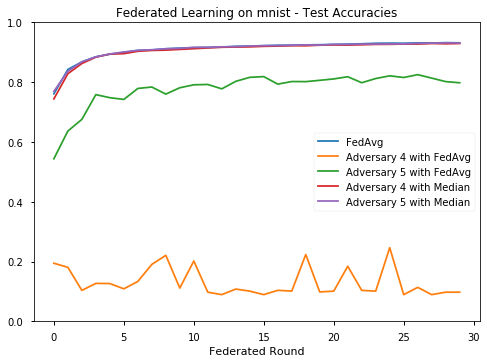

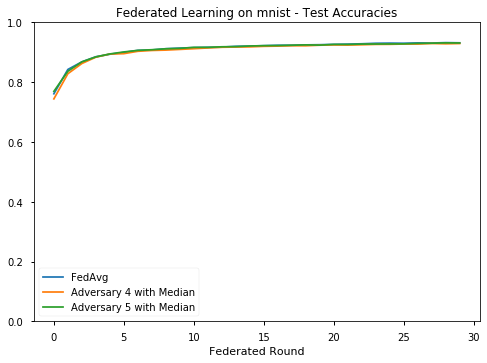

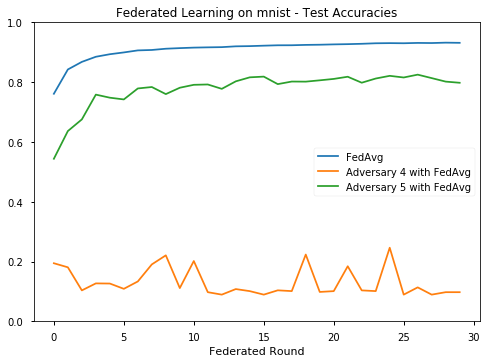

In [23]:
plotServerAccuracy([testAccs,testAccsAdvMean, testAccsAdv5Mean, testAccsAdv4Median, testAccsAdv5Median], ['FedAvg', 'Adversary 4 with FedAvg', 'Adversary 5 with FedAvg', 'Adversary 4 with Median', 'Adversary 5 with Median'], '1.jpg')
plotServerAccuracy([testAccs, testAccsAdv4Median, testAccsAdv5Median], ['FedAvg',  'Adversary 4 with Median', 'Adversary 5 with Median'], '2.jpg')
plotServerAccuracy([testAccs,testAccsAdvMean, testAccsAdv5Mean], ['FedAvg', 'Adversary 4 with FedAvg', 'Adversary 5 with FedAvg'], '3.jpg')


In [24]:
def plotClientAccuracy(clientAccs, isAdv, clientDesc, filename):
  plt.style.use('seaborn-notebook')

  legendCap = []

  for i in range(len(clientAccs)):
    if not isAdv[i]:
      legendCap.append(clientDesc[i])
      sns.lineplot(list(range(len(clientAccs[i]))), [v[0][0][1] for v in clientAccs[i]])
    else:
      legendCap.append(clientDesc[i] + ' (Adversary)')
      sns.lineplot(list(range(len(clientAccs[i]))), [v[0][0][1] for v in clientAccs[i]])
      legendCap.append(clientDesc[i] + ' (Honest)')
      sns.lineplot(list(range(len(clientAccs[i]))), [np.mean([v[i][0][1] for i in range(1,NUM_CLIENTS)]) for v in clientAccs[i]])

  plt.legend(legendCap, loc=0)
  plt.title('Federated Learning on mnist - Client Test Accuracies')
  plt.xlabel('Federated Round')
  plt.ylim(0, 1)
  plt.savefig(filename)
  plt.show()




In [ ]:
def myMedian(list_of_weights):
  # use median over all network weights
  robust_weights = []
  for layer in range(len(list_of_weights[0])):
    layer_shape = list_of_weights[0][layer].shape
    layer_list = [list_of_weights[i][layer].numpy().flatten() for i in range(len(list_of_weights))]
    robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
  return robust_weights

def myMedian(list_of_weights):
    
    # use median over all network weights
    robust_weights = []
    
    for i in range(len(list_of_weights[0])):
        layer_shape = list_of_weights[0][layer].shape
        layer_list = []
        for j in range(len(list_of_weights)):
            layer_list.append(list_of_weights[j][i].numpy().flatten())
        robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
        
    return robust_weights
        
        layer_list = [layer.numpy().flatten() for layer in list_of_weights[i]] 
        
    for i in range(len(list_of_weights)):
        
        for layer in list_of_weights[i]:
            layer_shape = layer.shape
            layer_list.append(layer)
        robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
        
    for layer in range(len(list_of_weights[0])):
        layer_shape = list_of_weights[0][layer].shape
        # numpy().flatten()
        layer_list = [layer.numpy().flatten() for layer in list_of_weights[i]]       
#        [list_of_weights[i][layer].Flatten() for i in range(len(list_of_weights))]
        robust_weights.append(np.median(layer_list, axis=0).reshape(layer_shape))
    return robust_weights

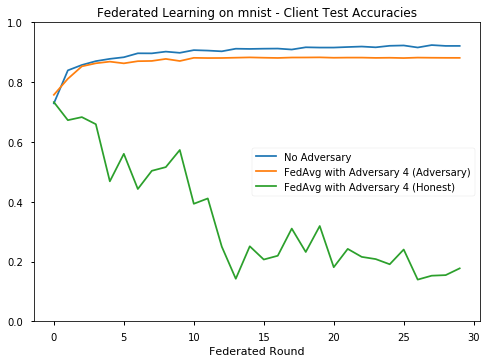

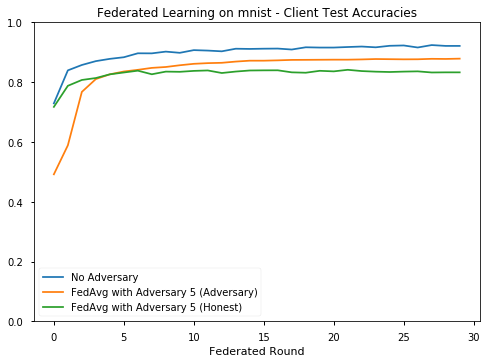

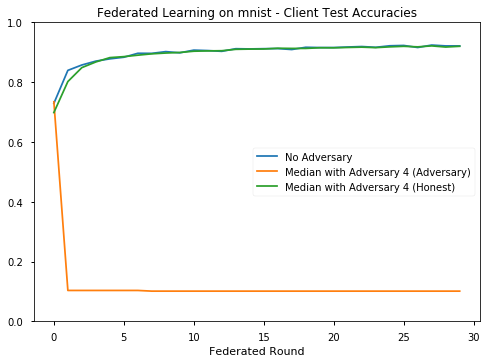

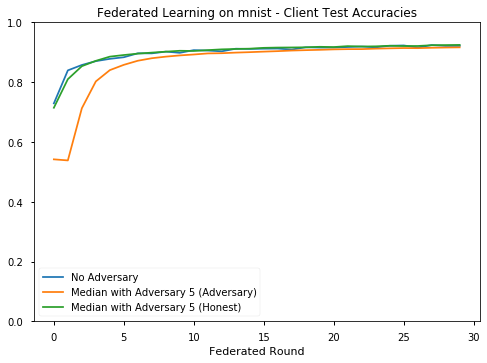

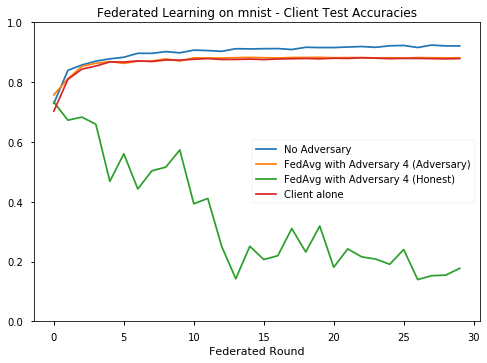

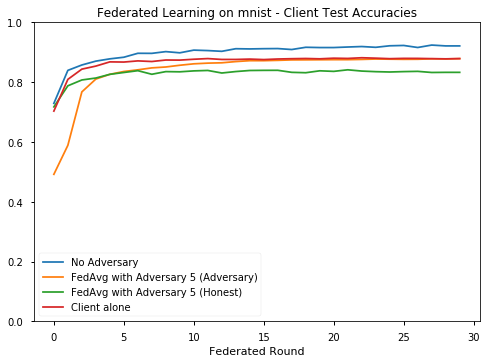

In [25]:
plotClientAccuracy([clientResults,clientResultsAdvMean], [False, True], ['No Adversary', 'FedAvg with Adversary 4'], '4.jpg')
plotClientAccuracy([clientResults,clientResultsAdv5Mean], [False, True], ['No Adversary', 'FedAvg with Adversary 5'], '5.jpg')
plotClientAccuracy([clientResults,clientResultsAdv4Median], [False, True], ['No Adversary', 'Median with Adversary 4'], '6.jpg')
plotClientAccuracy([clientResults,clientResultsAdv5Median], [False, True], ['No Adversary', 'Median with Adversary 5'], '7.jpg')

plotClientAccuracy([clientResults,clientResultsAdvMean, referenceAccs], [False, True, False], ['No Adversary', 'FedAvg with Adversary 4', 'Client alone'], '8.jpg')
plotClientAccuracy([clientResults,clientResultsAdv5Mean, referenceAccs], [False, True, False], ['No Adversary', 'FedAvg with Adversary 5', 'Client alone'], '9.jpg')

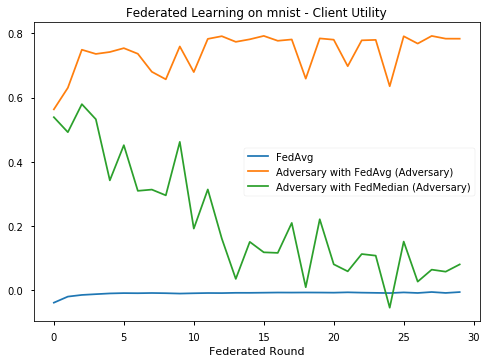

In [26]:
plt.style.use('seaborn-notebook')
sns.lineplot(list(range(len(testAccs))), [np.mean([v[i][1] for i in range(0,NUM_CLIENTS)]) for v in clientResults])
sns.lineplot(list(range(len(testAccsAdvMean))), [v[0][1] for v in clientResultsAdvMean])
#sns.lineplot(list(range(len(testAccsAdvMedian))), [v[0][1] for v in clientResultsAdvMedian])
sns.lineplot(list(range(len(testAccsAdvMean))), [np.mean([v[i][1] for i in range(1,NUM_CLIENTS)]) for v in clientResultsAdvMean])
#sns.lineplot(list(range(len(testAccsAdvMedian))), [v[1][1] for v in clientResultsAdvMedian])
#plt.legend(['FedAvg', 'Adversary with FedAvg (Adversary)', 'Adversary with FedMedian (Adversary)', 'Adversary with FedAvg (Good)', 'Adversary with FedMedian (Good)'], loc=0)
plt.legend(['FedAvg', 'Adversary with FedAvg (Adversary)', 'Adversary with FedMedian (Adversary)'], loc=0)
plt.title('Federated Learning on mnist - Client Utility')
plt.xlabel('Federated Round')
# plt.ylim(0, 1)
#plt.savefig('figs/allacc.jpg')
plt.show()